<a href="https://colab.research.google.com/github/Joaoluislins/Bayes_Variational_Autoencoder/blob/main/AEVB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AEVB

The objective of this project is to study the implementation of Bayes variational autoencoders. In the case here I'm using a convolutional VAE to analyze the latent space of three different datasets and try to generate new samples that resemble the original features of the training examples.

Project made for a paper study at the MS in Machine Learning at Stevens Intitute of technology. 

- Course: CS 583-A Deep Learning
- Student: João Luís Lins Rodrigues Cruz
- email: jlinsrod@stevens.edu

# Importing packages and data



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from google.colab import files
!pip install kaggle
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import cv2
import os
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from glob import glob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Mnist


## Create a sampling layer

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation= tf.keras.layers.LeakyReLU())(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

## Decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation = tf.keras.layers.LeakyReLU())(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Define the VAE as a Model with a custom train_step


In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE


In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11490434/11490434 [==============================] - 0s 0us/step


## Display a grid of sampled digits from the latent space



In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

##Display how the latent space clusters different digit classes

1875/1875 [==============================] - 14s 8ms/step


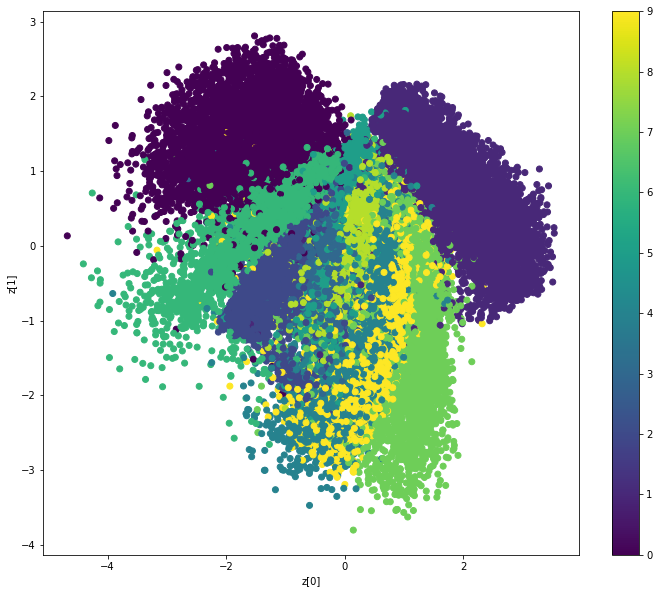

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

# Celeb dataset with ImagedataGenerator

## Preprocessing Celeb dataset

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


In [ ]:
kaggle_json = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!rm -rf /content/celeba-dataset.zip

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip /content/celeba-dataset.zip
!rm -rf /content/celeba-dataset.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_c

In [ ]:
# Reading all filenames from the dataset

path = "/content/img_align_celeba/img_align_celeba"

def images_upload(path):
    images=[]
    for root,subfolders,files in os.walk(path):
        for file in tqdm(files):
            filename=root+os.sep+file
            if filename.endswith('jpg') or filename.endswith('png'):
                images.append(filename)
    return images

images_names = images_upload(path)

100%|██████████| 202599/202599 [00:00<00:00, 1386829.58it/s]


In [ ]:
filenames = images_names

NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))
# prints : Total number of images : 202599


INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 258
Z_DIM = 200 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory('/content/img_align_celeba/', 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training' 
                                                                   )

Total number of images : 202599
Found 202599 images belonging to 1 classes.


## VAE Keras


### Create a sampling layer

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    @tf.function
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
shape = K.int_shape(x)
x = layers.Dense(shape[1]*shape[2]*shape[3], activation="relu")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 128)  73856       ['conv2d_1[0][0]']         

### Decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(shape[1]*shape[2]*shape[3], activation="relu")(latent_inputs)
x = layers.Reshape((shape[1], shape[2], shape[3]))(x)
x = layers.Conv2DTranspose(128, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation= tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation= tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.Conv2DTranspose(3, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
decoder_outputs = layers.Activation('sigmoid')(x)                               #layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x) 
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 8192)              24576     
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 32)       1846

### Define the VAE as a Model with a custom train_step


In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data[0])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(  
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data[0], reconstruction), axis=([1, 2])
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
  




### Train the VAE


In [ ]:
class EncoderCheckpoint(ModelCheckpoint):
  def __init__(self, filepath, **kwargs):
    super().__init__(filepath, **kwargs)
    self.model = encoder # we manually set encoder model

  def set_model(self, model):
    pass # ignore when Keras tries to set autoencoder model

class DecoderCheckpoint(ModelCheckpoint):
  def __init__(self, filepath, **kwargs):
    super().__init__(filepath, **kwargs)
    self.model = decoder # we manually set encoder model

  def set_model(self, model):
    pass # ignore when Keras tries to set autoencoder model

In [ ]:
batch_size = 258
epochs = 20

checkpoint_encoder = EncoderCheckpoint("/content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5", verbose = True, save_freq=int(200000/(batch_size*10))) # Saving the model by creating checkpoints
checkpoint_decoder = DecoderCheckpoint("/content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5", verbose = True, save_freq=int(200000/(batch_size*10))) # Saving the model by creating checkpoints

with tf.device(device_name):
  
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit_generator(data_flow, 
                            shuffle=True, 
                            epochs = epochs, 
                            initial_epoch = 0, 
                            steps_per_epoch=NUM_IMAGES / batch_size,
                            callbacks=[checkpoint_encoder, checkpoint_decoder])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/20
 76/785 [=>............................] - ETA: 4:21 - loss: 9922.0846 - reconstruction_loss: 9727.6025 - kl_loss: 8.4418
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


153/785 [====>.........................] - ETA: 3:54 - loss: 9813.6371 - reconstruction_loss: 9682.0703 - kl_loss: 8.2511
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


230/785 [=======>......................] - ETA: 3:33 - loss: 9768.4636 - reconstruction_loss: 9658.5107 - kl_loss: 8.1347
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


307/785 [==========>...................] - ETA: 3:04 - loss: 9742.7177 - reconstruction_loss: 9653.6523 - kl_loss: 8.0174
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


384/785 [=============>................] - ETA: 2:34 - loss: 9726.0935 - reconstruction_loss: 9649.2236 - kl_loss: 7.9522
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


461/785 [================>.............] - ETA: 2:05 - loss: 9714.1913 - reconstruction_loss: 9645.4805 - kl_loss: 7.9026
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


538/785 [===================>..........] - ETA: 1:36 - loss: 9705.1775 - reconstruction_loss: 9642.6318 - kl_loss: 7.8674
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


615/785 [======================>.......] - ETA: 1:06 - loss: 9698.1246 - reconstruction_loss: 9639.5635 - kl_loss: 7.8378
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


692/785 [=========================>....] - ETA: 36s - loss: 9692.3128 - reconstruction_loss: 9635.9170 - kl_loss: 7.8179
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


769/785 [============================>.] - ETA: 6s - loss: 9687.3276 - reconstruction_loss: 9633.3525 - kl_loss: 7.8070
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 317s 401ms/step - loss: 9686.2786 - reconstruction_loss: 9633.5391 - kl_loss: 7.8012
Epoch 2/20
 60/785 [=>............................] - ETA: 4:24 - loss: 9621.0841 - reconstruction_loss: 9608.7197 - kl_loss: 7.7410
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


137/785 [====>.........................] - ETA: 4:08 - loss: 9620.0093 - reconstruction_loss: 9608.3262 - kl_loss: 7.7217
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


214/785 [=======>......................] - ETA: 3:38 - loss: 9618.1120 - reconstruction_loss: 9609.0166 - kl_loss: 7.6943
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


291/785 [==========>...................] - ETA: 3:09 - loss: 9617.7076 - reconstruction_loss: 9609.2891 - kl_loss: 7.7060
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


368/785 [=============>................] - ETA: 2:41 - loss: 9618.0270 - reconstruction_loss: 9610.0254 - kl_loss: 7.7131
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


445/785 [================>.............] - ETA: 2:12 - loss: 9617.8428 - reconstruction_loss: 9609.8857 - kl_loss: 7.7252
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


522/785 [==================>...........] - ETA: 1:42 - loss: 9617.6963 - reconstruction_loss: 9608.5742 - kl_loss: 7.7296
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


599/785 [=====================>........] - ETA: 1:12 - loss: 9617.6038 - reconstruction_loss: 9608.9941 - kl_loss: 7.7285
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


676/785 [========================>.....] - ETA: 42s - loss: 9617.4332 - reconstruction_loss: 9608.6719 - kl_loss: 7.7349
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


753/785 [===========================>..] - ETA: 12s - loss: 9617.2561 - reconstruction_loss: 9607.2354 - kl_loss: 7.7333
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 310s 394ms/step - loss: 9617.1679 - reconstruction_loss: 9607.4258 - kl_loss: 7.7321
Epoch 3/20
 44/785 [>.............................] - ETA: 4:28 - loss: 9591.6961 - reconstruction_loss: 9584.0820 - kl_loss: 7.7942
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


121/785 [===>..........................] - ETA: 4:20 - loss: 9595.0875 - reconstruction_loss: 9590.7354 - kl_loss: 7.8096
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


198/785 [======>.......................] - ETA: 3:50 - loss: 9597.7772 - reconstruction_loss: 9596.8350 - kl_loss: 7.8224
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


275/785 [=========>....................] - ETA: 3:20 - loss: 9600.5772 - reconstruction_loss: 9599.8877 - kl_loss: 7.8055
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


352/785 [============>.................] - ETA: 2:50 - loss: 9602.5075 - reconstruction_loss: 9604.3105 - kl_loss: 7.7805
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


429/785 [===============>..............] - ETA: 2:20 - loss: 9604.0499 - reconstruction_loss: 9601.9492 - kl_loss: 7.7950
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


506/785 [==================>...........] - ETA: 1:49 - loss: 9604.8429 - reconstruction_loss: 9601.3486 - kl_loss: 7.7981
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


583/785 [=====================>........] - ETA: 1:19 - loss: 9605.2089 - reconstruction_loss: 9598.7979 - kl_loss: 7.7982
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


660/785 [========================>.....] - ETA: 48s - loss: 9605.4825 - reconstruction_loss: 9599.6270 - kl_loss: 7.7977
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


737/785 [===========================>..] - ETA: 18s - loss: 9605.7406 - reconstruction_loss: 9599.9941 - kl_loss: 7.7911
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 307s 391ms/step - loss: 9605.8664 - reconstruction_loss: 9599.5244 - kl_loss: 7.7891
Epoch 4/20
 28/785 [>.............................] - ETA: 4:31 - loss: 9600.7640 - reconstruction_loss: 9592.6465 - kl_loss: 7.9541
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


105/785 [===>..........................] - ETA: 4:18 - loss: 9601.6307 - reconstruction_loss: 9597.4990 - kl_loss: 7.8745
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


182/785 [=====>........................] - ETA: 3:51 - loss: 9604.1890 - reconstruction_loss: 9598.2139 - kl_loss: 7.8425
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


259/785 [========>.....................] - ETA: 3:24 - loss: 9604.1736 - reconstruction_loss: 9594.8184 - kl_loss: 7.8597
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


336/785 [===========>..................] - ETA: 2:53 - loss: 9603.9210 - reconstruction_loss: 9594.6494 - kl_loss: 7.8398
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


413/785 [==============>...............] - ETA: 2:22 - loss: 9603.6133 - reconstruction_loss: 9595.3721 - kl_loss: 7.8392
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


490/785 [=================>............] - ETA: 1:52 - loss: 9603.7810 - reconstruction_loss: 9597.4160 - kl_loss: 7.8302
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


567/785 [====================>.........] - ETA: 1:23 - loss: 9603.7997 - reconstruction_loss: 9594.4668 - kl_loss: 7.8455
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


644/785 [=======================>......] - ETA: 54s - loss: 9603.6816 - reconstruction_loss: 9594.6133 - kl_loss: 7.8477
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


721/785 [==========================>...] - ETA: 24s - loss: 9603.5732 - reconstruction_loss: 9594.3242 - kl_loss: 7.8563
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 304s 387ms/step - loss: 9603.4778 - reconstruction_loss: 9594.2256 - kl_loss: 7.8534
Epoch 5/20
 12/785 [..............................] - ETA: 4:34 - loss: 9609.6392 - reconstruction_loss: 9612.6348 - kl_loss: 7.8138
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


 89/785 [==>...........................] - ETA: 4:18 - loss: 9599.9066 - reconstruction_loss: 9595.0215 - kl_loss: 7.8738
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


166/785 [=====>........................] - ETA: 3:51 - loss: 9599.4703 - reconstruction_loss: 9593.3379 - kl_loss: 7.8907
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


243/785 [========>.....................] - ETA: 3:24 - loss: 9600.0983 - reconstruction_loss: 9592.0537 - kl_loss: 7.8974
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


320/785 [===========>..................] - ETA: 2:55 - loss: 9600.1373 - reconstruction_loss: 9592.5332 - kl_loss: 7.8875
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


397/785 [==============>...............] - ETA: 2:28 - loss: 9600.0224 - reconstruction_loss: 9591.7529 - kl_loss: 7.8882
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


474/785 [=================>............] - ETA: 1:58 - loss: 9600.0365 - reconstruction_loss: 9592.3135 - kl_loss: 7.8959
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


551/785 [====================>.........] - ETA: 1:29 - loss: 9600.0388 - reconstruction_loss: 9591.6855 - kl_loss: 7.8882
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


628/785 [======================>.......] - ETA: 1:00 - loss: 9600.0941 - reconstruction_loss: 9592.9316 - kl_loss: 7.8903
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


705/785 [=========================>....] - ETA: 30s - loss: 9600.1502 - reconstruction_loss: 9591.7900 - kl_loss: 7.9009
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


782/785 [============================>.] - ETA: 1s - loss: 9599.9995 - reconstruction_loss: 9590.5781 - kl_loss: 7.8960
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 301s 383ms/step - loss: 9599.9890 - reconstruction_loss: 9590.3984 - kl_loss: 7.8938
Epoch 6/20
 73/785 [=>............................] - ETA: 4:14 - loss: 9596.6644 - reconstruction_loss: 9572.7637 - kl_loss: 7.9202
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


150/785 [====>.........................] - ETA: 3:58 - loss: 9589.0991 - reconstruction_loss: 9574.2539 - kl_loss: 7.8852
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


227/785 [=======>......................] - ETA: 3:33 - loss: 9587.6080 - reconstruction_loss: 9580.6182 - kl_loss: 7.8682
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


304/785 [==========>...................] - ETA: 3:04 - loss: 9588.5504 - reconstruction_loss: 9583.9404 - kl_loss: 7.8714
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


381/785 [=============>................] - ETA: 2:34 - loss: 9589.6593 - reconstruction_loss: 9587.4648 - kl_loss: 7.8710
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


458/785 [================>.............] - ETA: 2:05 - loss: 9590.6240 - reconstruction_loss: 9588.2686 - kl_loss: 7.8695
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


535/785 [===================>..........] - ETA: 1:35 - loss: 9591.4728 - reconstruction_loss: 9589.3027 - kl_loss: 7.8762
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


612/785 [======================>.......] - ETA: 1:06 - loss: 9592.2419 - reconstruction_loss: 9589.4824 - kl_loss: 7.8787
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


689/785 [=========================>....] - ETA: 36s - loss: 9592.7599 - reconstruction_loss: 9588.4434 - kl_loss: 7.8828
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


766/785 [============================>.] - ETA: 7s - loss: 9593.0889 - reconstruction_loss: 9587.3535 - kl_loss: 7.8983
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 302s 385ms/step - loss: 9593.1489 - reconstruction_loss: 9587.6045 - kl_loss: 7.8984
Epoch 7/20
 57/785 [=>............................] - ETA: 4:29 - loss: 9577.3796 - reconstruction_loss: 9585.1631 - kl_loss: 7.9478
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


134/785 [====>.........................] - ETA: 4:04 - loss: 9586.0700 - reconstruction_loss: 9584.6484 - kl_loss: 7.8873
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


211/785 [=======>......................] - ETA: 3:36 - loss: 9588.8652 - reconstruction_loss: 9587.1943 - kl_loss: 7.9107
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


288/785 [==========>...................] - ETA: 3:06 - loss: 9590.1526 - reconstruction_loss: 9581.8496 - kl_loss: 7.9492
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


365/785 [============>.................] - ETA: 2:37 - loss: 9590.0738 - reconstruction_loss: 9583.2500 - kl_loss: 7.9657
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


442/785 [===============>..............] - ETA: 2:09 - loss: 9590.3193 - reconstruction_loss: 9584.2139 - kl_loss: 7.9719
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


519/785 [==================>...........] - ETA: 1:40 - loss: 9590.5849 - reconstruction_loss: 9584.6865 - kl_loss: 7.9747
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


596/785 [=====================>........] - ETA: 1:11 - loss: 9590.7510 - reconstruction_loss: 9583.6064 - kl_loss: 7.9774
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


673/785 [========================>.....] - ETA: 42s - loss: 9590.8618 - reconstruction_loss: 9583.1406 - kl_loss: 7.9673
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


750/785 [===========================>..] - ETA: 13s - loss: 9590.8957 - reconstruction_loss: 9584.4043 - kl_loss: 7.9665
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 298s 380ms/step - loss: 9590.9895 - reconstruction_loss: 9584.9033 - kl_loss: 7.9632
Epoch 8/20
 41/785 [>.............................] - ETA: 4:23 - loss: 9622.6652 - reconstruction_loss: 9606.2139 - kl_loss: 7.8954
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


118/785 [===>..........................] - ETA: 4:04 - loss: 9610.6839 - reconstruction_loss: 9594.7695 - kl_loss: 7.9322
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


195/785 [======>.......................] - ETA: 3:40 - loss: 9606.3559 - reconstruction_loss: 9591.4756 - kl_loss: 7.9833
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


272/785 [=========>....................] - ETA: 3:12 - loss: 9603.6290 - reconstruction_loss: 9585.8125 - kl_loss: 7.9895
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


349/785 [============>.................] - ETA: 2:43 - loss: 9601.3288 - reconstruction_loss: 9584.2646 - kl_loss: 7.9938
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


426/785 [===============>..............] - ETA: 2:14 - loss: 9599.8759 - reconstruction_loss: 9585.5664 - kl_loss: 7.9934
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


503/785 [==================>...........] - ETA: 1:46 - loss: 9598.7276 - reconstruction_loss: 9582.6006 - kl_loss: 7.9819
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


580/785 [=====================>........] - ETA: 1:17 - loss: 9597.7281 - reconstruction_loss: 9584.0713 - kl_loss: 7.9653
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


657/785 [========================>.....] - ETA: 48s - loss: 9596.8847 - reconstruction_loss: 9582.9736 - kl_loss: 7.9752
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


734/785 [===========================>..] - ETA: 19s - loss: 9596.3351 - reconstruction_loss: 9583.8418 - kl_loss: 7.9772
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 299s 380ms/step - loss: 9595.9349 - reconstruction_loss: 9582.1904 - kl_loss: 7.9847
Epoch 9/20
 25/785 [..............................] - ETA: 4:32 - loss: 9574.1993 - reconstruction_loss: 9574.4590 - kl_loss: 8.0578
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


102/785 [==>...........................] - ETA: 4:14 - loss: 9580.3916 - reconstruction_loss: 9570.0537 - kl_loss: 8.0310
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


179/785 [=====>........................] - ETA: 3:46 - loss: 9580.4955 - reconstruction_loss: 9575.3154 - kl_loss: 8.0109
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


256/785 [========>.....................] - ETA: 3:18 - loss: 9581.4404 - reconstruction_loss: 9575.7451 - kl_loss: 8.0234
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


333/785 [===========>..................] - ETA: 2:50 - loss: 9581.8496 - reconstruction_loss: 9573.9629 - kl_loss: 8.0276
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


410/785 [==============>...............] - ETA: 2:21 - loss: 9581.9350 - reconstruction_loss: 9574.8193 - kl_loss: 8.0196
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


487/785 [=================>............] - ETA: 1:52 - loss: 9582.1408 - reconstruction_loss: 9575.8281 - kl_loss: 8.0229
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


564/785 [====================>.........] - ETA: 1:23 - loss: 9582.2996 - reconstruction_loss: 9574.9805 - kl_loss: 8.0229
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


641/785 [=======================>......] - ETA: 54s - loss: 9582.5066 - reconstruction_loss: 9576.7217 - kl_loss: 8.0193
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


718/785 [==========================>...] - ETA: 25s - loss: 9582.8707 - reconstruction_loss: 9579.2920 - kl_loss: 8.0272
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 298s 379ms/step - loss: 9583.3241 - reconstruction_loss: 9580.2500 - kl_loss: 8.0270
Epoch 10/20
  9/785 [..............................] - ETA: 4:37 - loss: 9571.3806 - reconstruction_loss: 9584.2803 - kl_loss: 8.3071
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


 86/785 [==>...........................] - ETA: 4:23 - loss: 9575.7613 - reconstruction_loss: 9574.2490 - kl_loss: 8.1096
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


163/785 [=====>........................] - ETA: 3:56 - loss: 9578.2237 - reconstruction_loss: 9574.7305 - kl_loss: 8.0373
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


240/785 [========>.....................] - ETA: 3:30 - loss: 9580.4173 - reconstruction_loss: 9576.6709 - kl_loss: 7.9907
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


317/785 [===========>..................] - ETA: 2:59 - loss: 9581.4954 - reconstruction_loss: 9575.9678 - kl_loss: 8.0141
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


394/785 [==============>...............] - ETA: 2:30 - loss: 9582.0420 - reconstruction_loss: 9575.1221 - kl_loss: 8.0176
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


471/785 [================>.............] - ETA: 2:00 - loss: 9582.4232 - reconstruction_loss: 9577.8184 - kl_loss: 8.0395
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


548/785 [===================>..........] - ETA: 1:30 - loss: 9582.7958 - reconstruction_loss: 9577.1074 - kl_loss: 8.0464
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


625/785 [======================>.......] - ETA: 1:01 - loss: 9583.0602 - reconstruction_loss: 9577.6084 - kl_loss: 8.0500
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


702/785 [=========================>....] - ETA: 31s - loss: 9583.3119 - reconstruction_loss: 9577.5713 - kl_loss: 8.0479
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


779/785 [============================>.] - ETA: 2s - loss: 9583.5996 - reconstruction_loss: 9578.4395 - kl_loss: 8.0536
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 300s 382ms/step - loss: 9583.6276 - reconstruction_loss: 9578.2852 - kl_loss: 8.0524
Epoch 11/20
 70/785 [=>............................] - ETA: 4:29 - loss: 9589.9574 - reconstruction_loss: 9584.5889 - kl_loss: 8.0788
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


147/785 [====>.........................] - ETA: 4:03 - loss: 9590.6647 - reconstruction_loss: 9578.3848 - kl_loss: 8.1204
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


224/785 [=======>......................] - ETA: 3:33 - loss: 9588.3912 - reconstruction_loss: 9574.3896 - kl_loss: 8.1167
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


301/785 [==========>...................] - ETA: 3:03 - loss: 9587.3489 - reconstruction_loss: 9576.5234 - kl_loss: 8.1217
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


378/785 [=============>................] - ETA: 2:34 - loss: 9586.8121 - reconstruction_loss: 9576.6016 - kl_loss: 8.1189
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


455/785 [================>.............] - ETA: 2:05 - loss: 9586.3360 - reconstruction_loss: 9576.4990 - kl_loss: 8.1302
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


532/785 [===================>..........] - ETA: 1:36 - loss: 9586.0292 - reconstruction_loss: 9575.9229 - kl_loss: 8.1308
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


609/785 [======================>.......] - ETA: 1:06 - loss: 9585.8505 - reconstruction_loss: 9575.9160 - kl_loss: 8.1384
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


686/785 [=========================>....] - ETA: 37s - loss: 9585.7383 - reconstruction_loss: 9576.6152 - kl_loss: 8.1387
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


763/785 [============================>.] - ETA: 8s - loss: 9585.6084 - reconstruction_loss: 9576.6006 - kl_loss: 8.1405
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 301s 383ms/step - loss: 9585.5768 - reconstruction_loss: 9576.5684 - kl_loss: 8.1433
Epoch 12/20
 54/785 [=>............................] - ETA: 4:20 - loss: 9547.4651 - reconstruction_loss: 9554.1768 - kl_loss: 8.1185
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


131/785 [====>.........................] - ETA: 4:06 - loss: 9559.5289 - reconstruction_loss: 9564.4434 - kl_loss: 8.1563
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


208/785 [======>.......................] - ETA: 3:38 - loss: 9566.1384 - reconstruction_loss: 9573.2676 - kl_loss: 8.1741
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


285/785 [=========>....................] - ETA: 3:08 - loss: 9570.0269 - reconstruction_loss: 9571.8057 - kl_loss: 8.1674
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


362/785 [============>.................] - ETA: 2:40 - loss: 9572.6225 - reconstruction_loss: 9571.7324 - kl_loss: 8.1696
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


439/785 [===============>..............] - ETA: 2:11 - loss: 9573.9025 - reconstruction_loss: 9571.1943 - kl_loss: 8.1601
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


516/785 [==================>...........] - ETA: 1:43 - loss: 9574.8426 - reconstruction_loss: 9573.0654 - kl_loss: 8.1478
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


593/785 [=====================>........] - ETA: 1:13 - loss: 9575.7526 - reconstruction_loss: 9574.2969 - kl_loss: 8.1555
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


670/785 [========================>.....] - ETA: 44s - loss: 9576.4957 - reconstruction_loss: 9574.7197 - kl_loss: 8.1598
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


747/785 [===========================>..] - ETA: 14s - loss: 9577.1884 - reconstruction_loss: 9575.1924 - kl_loss: 8.1691
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 303s 385ms/step - loss: 9577.4976 - reconstruction_loss: 9574.9844 - kl_loss: 8.1758
Epoch 13/20
 38/785 [>.............................] - ETA: 4:30 - loss: 9584.5787 - reconstruction_loss: 9561.3408 - kl_loss: 8.2520
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


115/785 [===>..........................] - ETA: 4:09 - loss: 9578.9090 - reconstruction_loss: 9570.8262 - kl_loss: 8.1826
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


192/785 [======>.......................] - ETA: 3:44 - loss: 9580.4261 - reconstruction_loss: 9576.1016 - kl_loss: 8.1495
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


269/785 [=========>....................] - ETA: 3:15 - loss: 9581.3813 - reconstruction_loss: 9575.7998 - kl_loss: 8.2028
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


346/785 [============>.................] - ETA: 2:48 - loss: 9582.3574 - reconstruction_loss: 9578.3682 - kl_loss: 8.2015
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


423/785 [===============>..............] - ETA: 2:18 - loss: 9583.1103 - reconstruction_loss: 9578.6787 - kl_loss: 8.2016
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


500/785 [==================>...........] - ETA: 1:49 - loss: 9583.6430 - reconstruction_loss: 9578.0723 - kl_loss: 8.2083
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


577/785 [=====================>........] - ETA: 1:19 - loss: 9584.0731 - reconstruction_loss: 9577.8936 - kl_loss: 8.2186
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


654/785 [=======================>......] - ETA: 50s - loss: 9584.2069 - reconstruction_loss: 9575.3789 - kl_loss: 8.2153
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


731/785 [==========================>...] - ETA: 20s - loss: 9584.0470 - reconstruction_loss: 9574.2295 - kl_loss: 8.2128
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 301s 383ms/step - loss: 9583.9490 - reconstruction_loss: 9574.2578 - kl_loss: 8.2210
Epoch 14/20
 22/785 [..............................] - ETA: 4:32 - loss: 9571.5407 - reconstruction_loss: 9551.3555 - kl_loss: 8.2310
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


 99/785 [==>...........................] - ETA: 4:21 - loss: 9557.2145 - reconstruction_loss: 9554.6689 - kl_loss: 8.2324
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


176/785 [=====>........................] - ETA: 3:57 - loss: 9563.1286 - reconstruction_loss: 9565.4043 - kl_loss: 8.2302
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


253/785 [========>.....................] - ETA: 3:27 - loss: 9566.7024 - reconstruction_loss: 9568.0684 - kl_loss: 8.2260
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


330/785 [===========>..................] - ETA: 2:55 - loss: 9569.6156 - reconstruction_loss: 9572.2178 - kl_loss: 8.2431
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


407/785 [==============>...............] - ETA: 2:25 - loss: 9571.3664 - reconstruction_loss: 9569.1377 - kl_loss: 8.2551
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


484/785 [=================>............] - ETA: 1:55 - loss: 9572.1866 - reconstruction_loss: 9568.3242 - kl_loss: 8.2496
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


561/785 [====================>.........] - ETA: 1:25 - loss: 9572.9085 - reconstruction_loss: 9569.8506 - kl_loss: 8.2631
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


638/785 [=======================>......] - ETA: 56s - loss: 9573.5726 - reconstruction_loss: 9570.8154 - kl_loss: 8.2651
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


715/785 [==========================>...] - ETA: 26s - loss: 9574.2072 - reconstruction_loss: 9571.9277 - kl_loss: 8.2501
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 301s 383ms/step - loss: 9574.8096 - reconstruction_loss: 9573.4004 - kl_loss: 8.2499
Epoch 15/20
  6/785 [..............................] - ETA: 4:39 - loss: 9581.8587 - reconstruction_loss: 9588.7051 - kl_loss: 8.4960
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


 83/785 [==>...........................] - ETA: 4:24 - loss: 9585.7285 - reconstruction_loss: 9570.7900 - kl_loss: 8.2623
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


160/785 [=====>........................] - ETA: 3:56 - loss: 9584.9490 - reconstruction_loss: 9578.3467 - kl_loss: 8.2479
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


237/785 [========>.....................] - ETA: 3:27 - loss: 9584.8297 - reconstruction_loss: 9575.3760 - kl_loss: 8.2631
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


314/785 [==========>...................] - ETA: 2:59 - loss: 9584.3102 - reconstruction_loss: 9573.2588 - kl_loss: 8.2761
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


391/785 [=============>................] - ETA: 2:29 - loss: 9583.8305 - reconstruction_loss: 9573.4971 - kl_loss: 8.2823
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


468/785 [================>.............] - ETA: 2:00 - loss: 9583.5137 - reconstruction_loss: 9573.7617 - kl_loss: 8.2817
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


545/785 [===================>..........] - ETA: 1:31 - loss: 9583.2576 - reconstruction_loss: 9572.8418 - kl_loss: 8.2830
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


622/785 [======================>.......] - ETA: 1:02 - loss: 9582.9563 - reconstruction_loss: 9573.4277 - kl_loss: 8.2813
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


699/785 [=========================>....] - ETA: 32s - loss: 9582.7888 - reconstruction_loss: 9572.8643 - kl_loss: 8.2932
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


776/785 [============================>.] - ETA: 3s - loss: 9582.5493 - reconstruction_loss: 9571.5010 - kl_loss: 8.2876
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 302s 385ms/step - loss: 9582.5147 - reconstruction_loss: 9571.7812 - kl_loss: 8.2850
Epoch 16/20
 67/785 [=>............................] - ETA: 4:14 - loss: 9567.6902 - reconstruction_loss: 9564.1113 - kl_loss: 8.3797
Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


144/785 [====>.........................] - ETA: 3:58 - loss: 9570.2208 - reconstruction_loss: 9566.5605 - kl_loss: 8.3828
Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


221/785 [=======>......................] - ETA: 3:30 - loss: 9571.7447 - reconstruction_loss: 9565.9912 - kl_loss: 8.4025
Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


298/785 [==========>...................] - ETA: 3:02 - loss: 9572.8002 - reconstruction_loss: 9568.5449 - kl_loss: 8.3977
Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


375/785 [=============>................] - ETA: 2:34 - loss: 9573.9223 - reconstruction_loss: 9571.0283 - kl_loss: 8.3632
Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


452/785 [================>.............] - ETA: 2:06 - loss: 9574.6872 - reconstruction_loss: 9569.9111 - kl_loss: 8.3734
Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


529/785 [===================>..........] - ETA: 1:37 - loss: 9575.3976 - reconstruction_loss: 9570.4639 - kl_loss: 8.3739
Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


606/785 [======================>.......] - ETA: 1:08 - loss: 9575.7535 - reconstruction_loss: 9569.5244 - kl_loss: 8.3853
Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


683/785 [=========================>....] - ETA: 38s - loss: 9576.0950 - reconstruction_loss: 9571.3633 - kl_loss: 8.3682
Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


760/785 [============================>.] - ETA: 9s - loss: 9576.5121 - reconstruction_loss: 9572.4141 - kl_loss: 8.3730
Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 16: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 298s 380ms/step - loss: 9576.6679 - reconstruction_loss: 9572.3896 - kl_loss: 8.3737
Epoch 17/20
 51/785 [>.............................] - ETA: 4:19 - loss: 9572.9229 - reconstruction_loss: 9561.4170 - kl_loss: 8.3481
Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


128/785 [===>..........................] - ETA: 3:59 - loss: 9571.9153 - reconstruction_loss: 9573.3057 - kl_loss: 8.4094
Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


205/785 [======>.......................] - ETA: 3:37 - loss: 9575.1300 - reconstruction_loss: 9571.9141 - kl_loss: 8.3888
Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


282/785 [=========>....................] - ETA: 3:08 - loss: 9576.5052 - reconstruction_loss: 9571.4551 - kl_loss: 8.3840
Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


359/785 [============>.................] - ETA: 2:39 - loss: 9576.9585 - reconstruction_loss: 9570.3721 - kl_loss: 8.3828
Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


436/785 [===============>..............] - ETA: 2:10 - loss: 9577.2891 - reconstruction_loss: 9569.6924 - kl_loss: 8.3738
Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


513/785 [==================>...........] - ETA: 1:42 - loss: 9577.4922 - reconstruction_loss: 9570.2305 - kl_loss: 8.3944
Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


590/785 [=====================>........] - ETA: 1:13 - loss: 9577.6165 - reconstruction_loss: 9569.3008 - kl_loss: 8.3961
Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


667/785 [========================>.....] - ETA: 44s - loss: 9577.6644 - reconstruction_loss: 9569.4463 - kl_loss: 8.3964
Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


744/785 [===========================>..] - ETA: 15s - loss: 9577.7338 - reconstruction_loss: 9570.3691 - kl_loss: 8.4023
Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 17: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 298s 379ms/step - loss: 9577.7502 - reconstruction_loss: 9568.7803 - kl_loss: 8.4011
Epoch 18/20
 35/785 [>.............................] - ETA: 4:55 - loss: 9564.2736 - reconstruction_loss: 9546.0537 - kl_loss: 8.4116
Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


112/785 [===>..........................] - ETA: 4:21 - loss: 9566.4784 - reconstruction_loss: 9569.5674 - kl_loss: 8.4560
Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


189/785 [======>.......................] - ETA: 3:51 - loss: 9572.1114 - reconstruction_loss: 9570.3965 - kl_loss: 8.3896
Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


266/785 [=========>....................] - ETA: 3:18 - loss: 9574.9629 - reconstruction_loss: 9572.9893 - kl_loss: 8.3875
Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


343/785 [============>.................] - ETA: 2:49 - loss: 9576.2016 - reconstruction_loss: 9569.5391 - kl_loss: 8.4036
Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


420/785 [===============>..............] - ETA: 2:20 - loss: 9576.8220 - reconstruction_loss: 9571.3672 - kl_loss: 8.4027
Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


497/785 [=================>............] - ETA: 1:50 - loss: 9577.1646 - reconstruction_loss: 9567.6250 - kl_loss: 8.4148
Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


574/785 [====================>.........] - ETA: 1:21 - loss: 9577.0876 - reconstruction_loss: 9568.6650 - kl_loss: 8.4267
Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


651/785 [=======================>......] - ETA: 51s - loss: 9577.0875 - reconstruction_loss: 9569.1279 - kl_loss: 8.4310
Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


728/785 [==========================>...] - ETA: 22s - loss: 9577.1657 - reconstruction_loss: 9569.4668 - kl_loss: 8.4328
Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 18: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 303s 385ms/step - loss: 9577.1772 - reconstruction_loss: 9568.7168 - kl_loss: 8.4417
Epoch 19/20
 19/785 [..............................] - ETA: 4:33 - loss: 9609.5552 - reconstruction_loss: 9611.5391 - kl_loss: 8.6559
Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


 96/785 [==>...........................] - ETA: 4:15 - loss: 9589.0851 - reconstruction_loss: 9563.2510 - kl_loss: 8.5732
Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


173/785 [=====>........................] - ETA: 3:51 - loss: 9582.5893 - reconstruction_loss: 9563.7549 - kl_loss: 8.5601
Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


250/785 [========>.....................] - ETA: 3:21 - loss: 9580.0659 - reconstruction_loss: 9564.6865 - kl_loss: 8.5091
Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


327/785 [===========>..................] - ETA: 2:52 - loss: 9578.8928 - reconstruction_loss: 9569.4424 - kl_loss: 8.5130
Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


404/785 [==============>...............] - ETA: 2:23 - loss: 9578.6396 - reconstruction_loss: 9570.4199 - kl_loss: 8.5065
Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


481/785 [=================>............] - ETA: 1:55 - loss: 9578.4835 - reconstruction_loss: 9567.8027 - kl_loss: 8.5176
Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


558/785 [====================>.........] - ETA: 1:26 - loss: 9578.2609 - reconstruction_loss: 9569.0430 - kl_loss: 8.5225
Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


635/785 [=======================>......] - ETA: 57s - loss: 9578.1210 - reconstruction_loss: 9567.4668 - kl_loss: 8.5292
Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


712/785 [==========================>...] - ETA: 27s - loss: 9577.9198 - reconstruction_loss: 9567.9111 - kl_loss: 8.5106
Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 19: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 298s 380ms/step - loss: 9577.7908 - reconstruction_loss: 9567.7383 - kl_loss: 8.5133
Epoch 20/20
  3/785 [..............................] - ETA: 4:56 - loss: 9470.1377 - reconstruction_loss: 9463.6016 - kl_loss: 8.6206
Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


 80/785 [==>...........................] - ETA: 4:23 - loss: 9571.0906 - reconstruction_loss: 9563.0000 - kl_loss: 8.5332
Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


157/785 [====>.........................] - ETA: 3:59 - loss: 9571.5554 - reconstruction_loss: 9564.3184 - kl_loss: 8.5096
Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


234/785 [=======>......................] - ETA: 3:28 - loss: 9570.9495 - reconstruction_loss: 9563.8672 - kl_loss: 8.5304
Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


311/785 [==========>...................] - ETA: 3:02 - loss: 9570.6925 - reconstruction_loss: 9562.6318 - kl_loss: 8.5139
Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


388/785 [=============>................] - ETA: 2:32 - loss: 9571.4816 - reconstruction_loss: 9567.1436 - kl_loss: 8.5330
Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


465/785 [================>.............] - ETA: 2:02 - loss: 9572.0058 - reconstruction_loss: 9565.5615 - kl_loss: 8.5174
Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


542/785 [===================>..........] - ETA: 1:33 - loss: 9572.3917 - reconstruction_loss: 9566.0840 - kl_loss: 8.5242
Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


619/785 [======================>.......] - ETA: 1:03 - loss: 9572.7386 - reconstruction_loss: 9566.6504 - kl_loss: 8.5223
Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


696/785 [=========================>....] - ETA: 34s - loss: 9573.0973 - reconstruction_loss: 9567.2461 - kl_loss: 8.5410
Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


773/785 [============================>.] - ETA: 4s - loss: 9573.4075 - reconstruction_loss: 9567.3408 - kl_loss: 8.5402
Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5



Epoch 20: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5


785/785 [==============================] - 302s 384ms/step - loss: 9573.4458 - reconstruction_loss: 9566.8115 - kl_loss: 8.5421


### Recover last training

In [ ]:
decoder = keras.models.load_model('/content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder.h5')
encoder = keras.models.load_model('/content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder.h5', custom_objects={'Sampling': Sampling()})

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

### Display a grid of sampled images


1/1 [==============================] - 0s 23ms/step


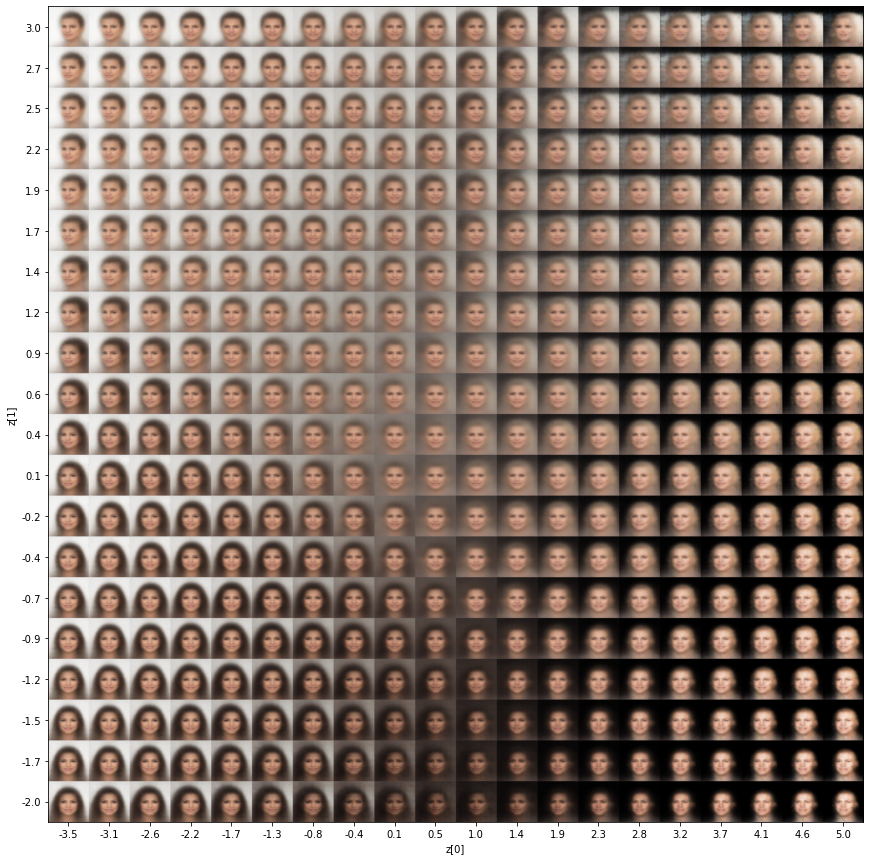

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=20, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n,3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-3.5, 5, n)
    grid_y = np.linspace(-2, 3, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size,3)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

###Display how the latent space is formed

In [ ]:
data_flow_no_shuffle_full = ImageDataGenerator(rescale=1./255).flow_from_directory('/content/img_align_celeba/', 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = 1000,
                                                                   shuffle = False,
                                                                   class_mode = 'input',
                                                                   subset = 'training' 
                                                                   )

Found 202599 images belonging to 1 classes.


In [ ]:
###work in progress, dont use this cell

filename = 'bigdata.bin'
fd = open(filename, 'ab')

for i in range(len(data_flow_no_shuffle_full)):
  batch = data_flow_no_shuffle_full[i]
  batch[0].tofile(filename, sep='', format='%s')
  del batch
fd.close()

In [ ]:
### use this cell, but mind that you are only plotting 10000 data points
all_data = []
for i in range(10):
  all_data.extend(data_flow_no_shuffle_full[i])

32/32 [==============================] - 0s 10ms/step


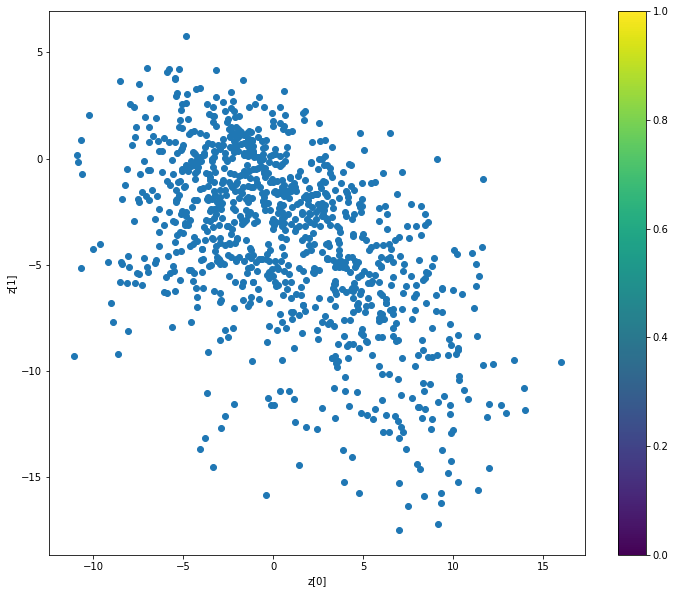

In [ ]:
### Celeb dataset

def plot_latent_space(vae, data):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data[0])
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


plot_latent_space(vae, all_data)

In [ ]:
batch = data_flow_no_shuffle_full[0]
image1 = batch[0][0]
image2 = batch[0][1]

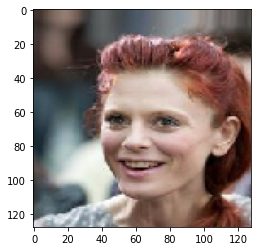

In [ ]:
plt.imshow(image2)

In [ ]:
reconstruc,_,_ = encoder(image2.reshape(1,128,128,3))
reconstruc = decoder(reconstruc)

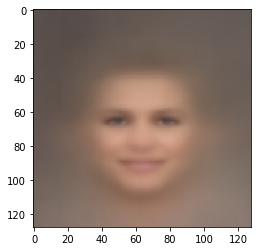

In [ ]:
plt.clf()
plt.imshow(np.reshape(reconstruc,(128,128,3)))

# Face dataset with cv2

## Face and cv2

In [ ]:
kaggle_json = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Providing colab with kaggle permission to download datasets and downloading it

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d ashwingupta3012/human-faces
!unzip /content/human-faces.zip

In [ ]:
# Reading all filenames from the dataset

path = "/content/Humans/"

def images_upload(path):
    images=[]
    for root,subfolders,files in os.walk(path):
        for file in tqdm(files):
            filename=root+os.sep+file
            if filename.endswith('jpg') or filename.endswith('png'):
                images.append(filename)
    return images

images_names = images_upload(path)

100%|██████████| 7219/7219 [00:00<00:00, 1547752.42it/s]


In [ ]:
# Converting images to 128vs128 size

def convert_image_inputs(images):
    inputs=[]
    for i in tqdm(images):
        i = cv2.imread(i)
        i=cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
        res_i=cv2.resize(i,(128,128))
        del i
        inputs.append(res_i)
    return inputs

In [ ]:
images_pixels = convert_image_inputs(images_names)

100%|██████████| 7123/7123 [02:49<00:00, 41.97it/s]


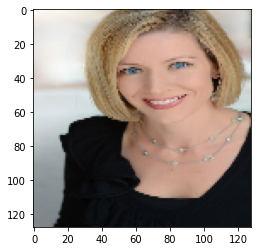

In [ ]:
#plt.figure(figsize = (128,128))
plt.imshow(images_pixels[5232]) #5232 #538
plt.show()

## VAE Keras


### Create a sampling layer

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    @tf.function
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
shape = K.int_shape(x)
x = layers.Dense(shape[1]*shape[2]*shape[3], activation="relu")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 128)  73856       ['conv2d_1[0][0]']         

### Decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(shape[1]*shape[2]*shape[3], activation="relu")(latent_inputs)
x = layers.Reshape((shape[1], shape[2], shape[3]))(x)
x = layers.Conv2DTranspose(128, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation= tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation= tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
x = layers.Conv2DTranspose(3, 3, activation = tf.keras.layers.LeakyReLU(), strides=2, padding="same")(x)
decoder_outputs = layers.Activation('sigmoid')(x)                               #layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x) 
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 8192)              24576     
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 32)       1846

### Define the VAE as a Model with a custom train_step


In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data[0])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(  
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data[0], reconstruction), axis=([1, 2])
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
  




### Train the VAE


In [ ]:
class EncoderCheckpoint(ModelCheckpoint):
  def __init__(self, filepath, **kwargs):
    super().__init__(filepath, **kwargs)
    self.model = encoder # we manually set encoder model

  def set_model(self, model):
    pass # ignore when Keras tries to set autoencoder model

class DecoderCheckpoint(ModelCheckpoint):
  def __init__(self, filepath, **kwargs):
    super().__init__(filepath, **kwargs)
    self.model = decoder # we manually set encoder model

  def set_model(self, model):
    pass # ignore when Keras tries to set autoencoder model

In [ ]:
batch_size = 516
epochs = 15
#images_array = np.array(images_pixels).astype("float32") / 255
checkpoint_encoder = EncoderCheckpoint("/content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder", verbose = True, save_freq=int(200000/(batch_size*4))) # Saving the model by creating checkpoints
checkpoint_decoder = DecoderCheckpoint("/content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder", verbose = True, save_freq=int(200000/(batch_size*4))) # Saving the model by creating checkpoints

with tf.device(device_name):
  
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit_generator(data_flow, 
                            shuffle=True, 
                            epochs = epochs, 
                            initial_epoch = 0, 
                            steps_per_epoch=NUM_IMAGES / batch_size,
                            callbacks=[checkpoint_encoder, checkpoint_decoder])
#vae.fit(images_array, epochs=10, batch_size=batch_size, callbacks = [checkpoint_encoder, checkpoint_decoder])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/15
 95/392 [======>.......................] - ETA: 3:43 - loss: 11009.7316 - reconstruction_loss: 10627.8457 - kl_loss: 11.5614
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


191/392 [=============>................] - ETA: 2:38 - loss: 10693.8504 - reconstruction_loss: 10193.6318 - kl_loss: 10.7827
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


287/392 [====================>.........] - ETA: 1:22 - loss: 10498.1317 - reconstruction_loss: 10024.3916 - kl_loss: 10.1530
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


383/392 [============================>.] - ETA: 7s - loss: 10369.1734 - reconstruction_loss: 9933.7002 - kl_loss: 9.7445
Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 1: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 318s 808ms/step - loss: 10357.1555 - reconstruction_loss: 9925.8516 - kl_loss: 9.7101
Epoch 2/15
 86/392 [=====>........................] - ETA: 3:42 - loss: 9653.4395 - reconstruction_loss: 9648.9736 - kl_loss: 8.3436
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


182/392 [============>.................] - ETA: 2:34 - loss: 9654.6999 - reconstruction_loss: 9649.4346 - kl_loss: 8.2713
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


278/392 [====================>.........] - ETA: 1:24 - loss: 9654.9179 - reconstruction_loss: 9643.7744 - kl_loss: 8.2219
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


374/392 [===========================>..] - ETA: 13s - loss: 9653.5555 - reconstruction_loss: 9639.5615 - kl_loss: 8.1730
Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 2: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 294s 747ms/step - loss: 9653.2269 - reconstruction_loss: 9638.2139 - kl_loss: 8.1650
Epoch 3/15
 77/392 [====>.........................] - ETA: 3:42 - loss: 9636.9826 - reconstruction_loss: 9632.3818 - kl_loss: 7.9963
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


173/392 [============>.................] - ETA: 2:38 - loss: 9637.2265 - reconstruction_loss: 9629.3018 - kl_loss: 7.9570
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


269/392 [===================>..........] - ETA: 1:29 - loss: 9636.3989 - reconstruction_loss: 9624.4707 - kl_loss: 7.9325
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


365/392 [==========================>...] - ETA: 19s - loss: 9634.6416 - reconstruction_loss: 9618.9707 - kl_loss: 7.9274
Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 3: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 287s 730ms/step - loss: 9634.0757 - reconstruction_loss: 9618.3457 - kl_loss: 7.9196
Epoch 4/15
 68/392 [====>.........................] - ETA: 3:49 - loss: 9623.3530 - reconstruction_loss: 9619.5947 - kl_loss: 7.8081
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


164/392 [===========>..................] - ETA: 2:44 - loss: 9622.3583 - reconstruction_loss: 9611.6963 - kl_loss: 7.8113
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


260/392 [==================>...........] - ETA: 1:36 - loss: 9620.8883 - reconstruction_loss: 9610.1289 - kl_loss: 7.8232
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


356/392 [==========================>...] - ETA: 26s - loss: 9619.6974 - reconstruction_loss: 9605.4639 - kl_loss: 7.8116
Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 4: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 287s 731ms/step - loss: 9619.1028 - reconstruction_loss: 9605.7754 - kl_loss: 7.8096
Epoch 5/15
 59/392 [===>..........................] - ETA: 3:51 - loss: 9613.8133 - reconstruction_loss: 9607.4551 - kl_loss: 7.7684
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


155/392 [==========>...................] - ETA: 2:50 - loss: 9610.9709 - reconstruction_loss: 9598.6309 - kl_loss: 7.7471
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


251/392 [==================>...........] - ETA: 1:41 - loss: 9609.3668 - reconstruction_loss: 9598.7578 - kl_loss: 7.7506
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


347/392 [=========================>....] - ETA: 32s - loss: 9608.4363 - reconstruction_loss: 9597.2549 - kl_loss: 7.7551
Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 5: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 285s 725ms/step - loss: 9608.0990 - reconstruction_loss: 9598.5137 - kl_loss: 7.7528
Epoch 6/15
 50/392 [==>...........................] - ETA: 3:58 - loss: 9598.3163 - reconstruction_loss: 9590.4473 - kl_loss: 7.7791
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


146/392 [==========>...................] - ETA: 2:55 - loss: 9600.3169 - reconstruction_loss: 9593.9014 - kl_loss: 7.7497
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


242/392 [=================>............] - ETA: 1:47 - loss: 9600.6149 - reconstruction_loss: 9590.3809 - kl_loss: 7.7501
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


338/392 [========================>.....] - ETA: 39s - loss: 9600.3609 - reconstruction_loss: 9592.4033 - kl_loss: 7.7465
Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 6: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 284s 722ms/step - loss: 9600.1800 - reconstruction_loss: 9591.8828 - kl_loss: 7.7417
Epoch 7/15
 41/392 [==>...........................] - ETA: 4:03 - loss: 9596.6198 - reconstruction_loss: 9588.7637 - kl_loss: 7.7433
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


137/392 [=========>....................] - ETA: 3:01 - loss: 9597.7541 - reconstruction_loss: 9588.9854 - kl_loss: 7.7514
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


233/392 [================>.............] - ETA: 1:53 - loss: 9597.3803 - reconstruction_loss: 9588.2637 - kl_loss: 7.7457
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


329/392 [========================>.....] - ETA: 45s - loss: 9596.9585 - reconstruction_loss: 9586.9668 - kl_loss: 7.7461
Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 7: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 281s 715ms/step - loss: 9596.5838 - reconstruction_loss: 9587.2256 - kl_loss: 7.7374
Epoch 8/15
 32/392 [=>............................] - ETA: 4:11 - loss: 9611.5497 - reconstruction_loss: 9586.0830 - kl_loss: 7.6845
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


128/392 [========>.....................] - ETA: 3:08 - loss: 9601.2426 - reconstruction_loss: 9588.0547 - kl_loss: 7.7629
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


224/392 [================>.............] - ETA: 2:00 - loss: 9598.5430 - reconstruction_loss: 9587.5879 - kl_loss: 7.7609
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


320/392 [=======================>......] - ETA: 52s - loss: 9596.9601 - reconstruction_loss: 9585.0176 - kl_loss: 7.7555
Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 8: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 283s 719ms/step - loss: 9596.0362 - reconstruction_loss: 9584.1436 - kl_loss: 7.7522
Epoch 9/15
 23/392 [>.............................] - ETA: 4:17 - loss: 9589.8708 - reconstruction_loss: 9556.1924 - kl_loss: 7.7677
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


119/392 [========>.....................] - ETA: 3:14 - loss: 9577.4070 - reconstruction_loss: 9572.5566 - kl_loss: 7.7891
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


215/392 [===============>..............] - ETA: 2:07 - loss: 9580.6238 - reconstruction_loss: 9579.9316 - kl_loss: 7.7489
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


311/392 [======================>.......] - ETA: 58s - loss: 9582.9052 - reconstruction_loss: 9578.9795 - kl_loss: 7.7627
Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 9: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 283s 719ms/step - loss: 9583.9587 - reconstruction_loss: 9580.4287 - kl_loss: 7.7605
Epoch 10/15
 14/392 [>.............................] - ETA: 4:20 - loss: 9552.0447 - reconstruction_loss: 9559.8809 - kl_loss: 7.6722
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


110/392 [=======>......................] - ETA: 3:21 - loss: 9577.4022 - reconstruction_loss: 9569.5352 - kl_loss: 7.6863
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


206/392 [==============>...............] - ETA: 2:12 - loss: 9578.3016 - reconstruction_loss: 9572.4189 - kl_loss: 7.7345
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


302/392 [======================>.......] - ETA: 1:04 - loss: 9579.1634 - reconstruction_loss: 9574.5469 - kl_loss: 7.7409
Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 10: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 282s 717ms/step - loss: 9580.2237 - reconstruction_loss: 9576.4932 - kl_loss: 7.7286
Epoch 11/15
  5/392 [..............................] - ETA: 4:28 - loss: 9643.9072 - reconstruction_loss: 9619.9941 - kl_loss: 7.5790
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


101/392 [======>.......................] - ETA: 3:30 - loss: 9594.1269 - reconstruction_loss: 9580.5020 - kl_loss: 7.7241
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


197/392 [==============>...............] - ETA: 2:20 - loss: 9590.1012 - reconstruction_loss: 9577.4180 - kl_loss: 7.7250
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


293/392 [=====================>........] - ETA: 1:11 - loss: 9588.2152 - reconstruction_loss: 9577.7627 - kl_loss: 7.7563
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


389/392 [============================>.] - ETA: 2s - loss: 9587.4260 - reconstruction_loss: 9574.8467 - kl_loss: 7.7513
Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 11: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 285s 724ms/step - loss: 9587.3660 - reconstruction_loss: 9574.9990 - kl_loss: 7.7499
Epoch 12/15
 92/392 [======>.......................] - ETA: 3:27 - loss: 9571.7650 - reconstruction_loss: 9568.6680 - kl_loss: 7.7618
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


188/392 [=============>................] - ETA: 2:23 - loss: 9574.8368 - reconstruction_loss: 9570.9688 - kl_loss: 7.7650
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


284/392 [====================>.........] - ETA: 1:16 - loss: 9576.0215 - reconstruction_loss: 9571.3594 - kl_loss: 7.7727
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


380/392 [============================>.] - ETA: 8s - loss: 9576.8336 - reconstruction_loss: 9572.3047 - kl_loss: 7.7552
Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 12: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 281s 715ms/step - loss: 9576.9625 - reconstruction_loss: 9572.8838 - kl_loss: 7.7549
Epoch 13/15
 83/392 [=====>........................] - ETA: 3:35 - loss: 9584.2911 - reconstruction_loss: 9575.0107 - kl_loss: 7.8011
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


179/392 [============>.................] - ETA: 2:33 - loss: 9581.5233 - reconstruction_loss: 9572.5146 - kl_loss: 7.8016
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


275/392 [====================>.........] - ETA: 1:24 - loss: 9581.4010 - reconstruction_loss: 9573.4805 - kl_loss: 7.7784
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


371/392 [===========================>..] - ETA: 15s - loss: 9580.9896 - reconstruction_loss: 9570.7490 - kl_loss: 7.7895
Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 13: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 283s 721ms/step - loss: 9580.8309 - reconstruction_loss: 9570.1602 - kl_loss: 7.7838
Epoch 14/15
 74/392 [====>.........................] - ETA: 3:44 - loss: 9580.0347 - reconstruction_loss: 9572.7773 - kl_loss: 7.8333
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


170/392 [===========>..................] - ETA: 2:38 - loss: 9581.2477 - reconstruction_loss: 9572.2549 - kl_loss: 7.8058
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


266/392 [===================>..........] - ETA: 1:30 - loss: 9580.5475 - reconstruction_loss: 9571.5527 - kl_loss: 7.8079
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


362/392 [==========================>...] - ETA: 21s - loss: 9580.3568 - reconstruction_loss: 9570.9795 - kl_loss: 7.8225
Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 14: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 283s 720ms/step - loss: 9580.1450 - reconstruction_loss: 9569.8730 - kl_loss: 7.8252
Epoch 15/15
 65/392 [===>..........................] - ETA: 3:45 - loss: 9570.2039 - reconstruction_loss: 9565.6953 - kl_loss: 7.8185
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


161/392 [===========>..................] - ETA: 2:42 - loss: 9574.5264 - reconstruction_loss: 9571.8965 - kl_loss: 7.8012
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


257/392 [==================>...........] - ETA: 1:36 - loss: 9576.6891 - reconstruction_loss: 9570.1777 - kl_loss: 7.8081
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


353/392 [=========================>....] - ETA: 28s - loss: 9576.7386 - reconstruction_loss: 9566.9648 - kl_loss: 7.8212
Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/encoder



Epoch 15: saving model to /content/drive/MyDrive/Stevens/Deep Learning/Autoencoder_celeb/decoder


392/392 [==============================] - 290s 738ms/step - loss: 9576.6105 - reconstruction_loss: 9567.8516 - kl_loss: 7.8240


### Display a grid of sampled images


1/1 [==============================] - 0s 23ms/step


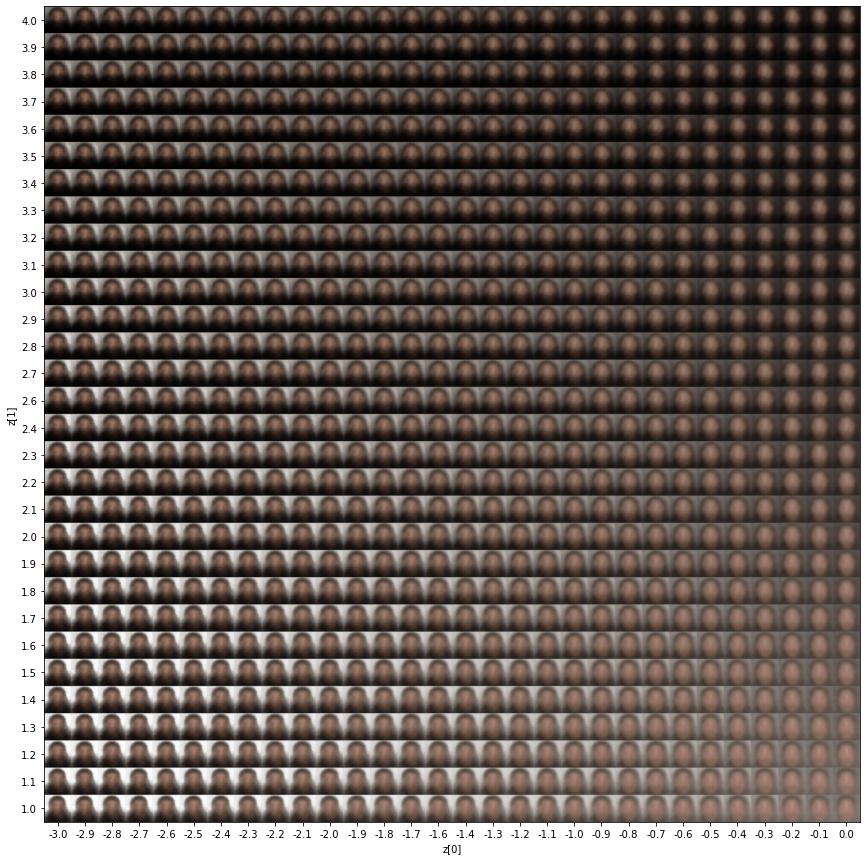

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n,3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-3, 0, n)
    grid_y = np.linspace(1, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size,3)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

###Display how the latent space is formed

223/223 [==============================] - 43s 190ms/step


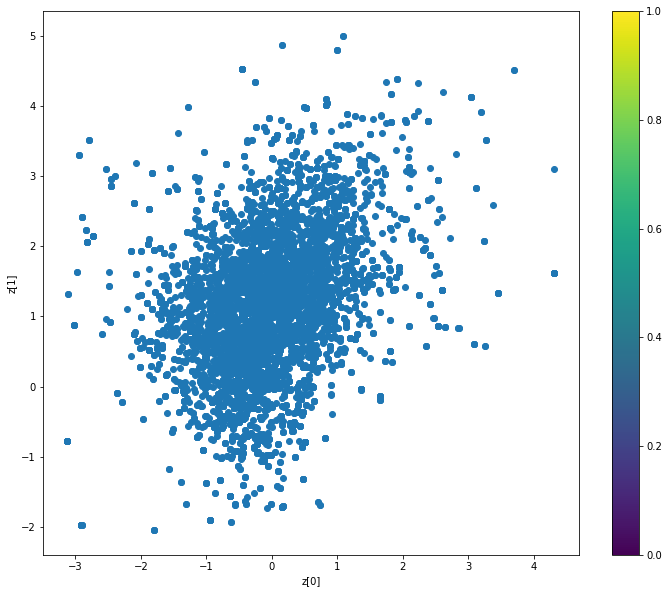

In [ ]:
### Face Images

def plot_latent_space(vae, data):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


plot_latent_space(vae, images_array)

In [ ]:
reconstruc,_,_ = encoder(images_array[5232].reshape(1,128,128,3))
reconstruc = decoder(reconstruc)

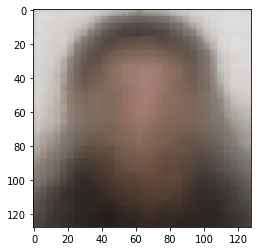

In [ ]:
plt.clf()
plt.imshow(np.reshape(reconstruc,(128,128,3)))